In [44]:
import pandas as pd

# Load FD001 dataset
file_path = "../data/train_FD001.txt"
col_names = ["unit", "time", "op_set_1", "op_set_2", "op_set_3"] + [f"s{i}" for i in range(1, 22)]
df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)

# Compute RUL
df['RUL'] = df.groupby('unit')['time'].transform('max') - df['time']

# Display first few rows
print(df.head())


   unit  time  op_set_1  op_set_2  op_set_3      s1      s2       s3       s4  \
0     1     1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1     1     2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2     1     3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3     1     4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4     1     5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

       s21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  18

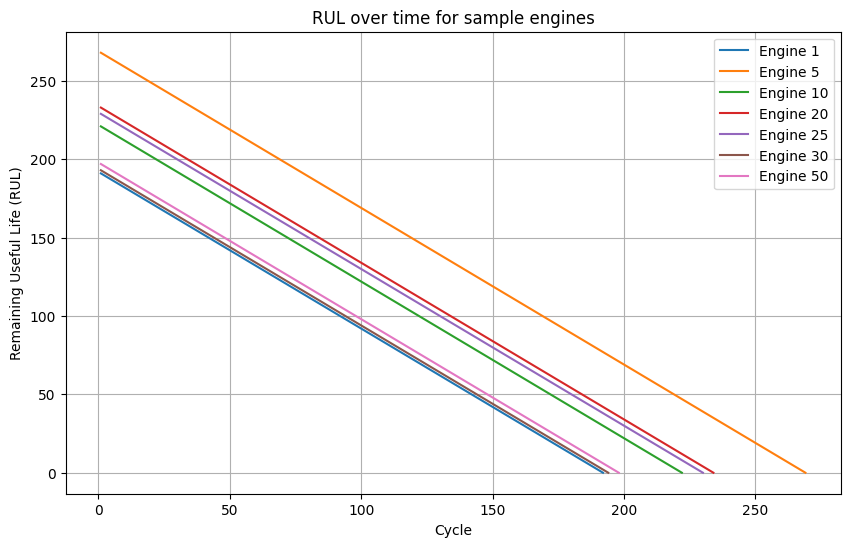

In [45]:
import matplotlib.pyplot as plt

# Pick a few engine units to visualize
sample_units = [1, 5, 10, 20, 25, 30, 50]

plt.figure(figsize=(10, 6))
for unit_id in sample_units:
    unit_df = df[df['unit'] == unit_id]
    plt.plot(unit_df['time'], unit_df['RUL'], label=f'Engine {unit_id}')

plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('RUL over time for sample engines')
plt.legend()
plt.grid(True)
plt.show()


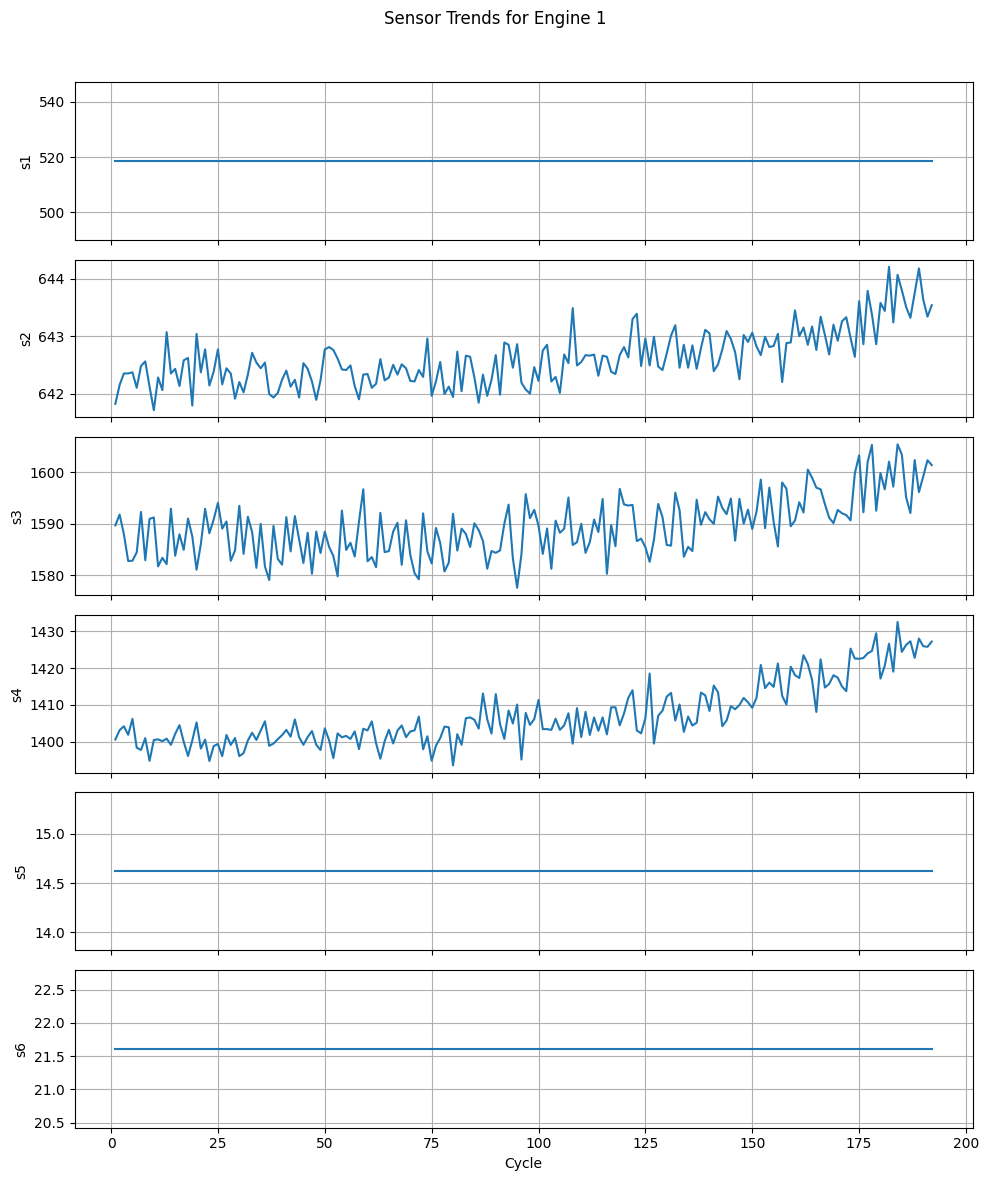

In [46]:
# Pick one engine
engine_id = 1
engine_df = df[df['unit'] == engine_id]

sensor_cols = [f's{i}' for i in range(1, 22)]  # sensors s1 to s21
plot_cols = sensor_cols[:6]  # pick first 6 for now (avoid clutter)

engine_df = engine_df.reset_index(drop=True)
fig, axs = plt.subplots(len(plot_cols), 1, figsize=(10, 12), sharex=True)

for i, col in enumerate(plot_cols):
    axs[i].plot(engine_df['time'], engine_df[col])
    axs[i].set_ylabel(col)
    axs[i].grid(True)

axs[-1].set_xlabel("Cycle")
plt.suptitle(f"Sensor Trends for Engine {engine_id}")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [47]:
#Sensor Variability 
sensor_cols = [f's{i}' for i in range(1, 22)]  # sensors s1 to s21
#sensor_means = df[sensor_cols].mean()
sensor_stds = df[sensor_cols].std()
#print("Sensor Means:")
#print(sensor_means)
print("\nSensor Standard Deviations:")
print(sensor_stds)


Sensor Standard Deviations:
s1     0.000000e+00
s2     5.000533e-01
s3     6.131150e+00
s4     9.000605e+00
s5     1.776400e-15
s6     1.388985e-03
s7     8.850923e-01
s8     7.098548e-02
s9     2.208288e+01
s10    0.000000e+00
s11    2.670874e-01
s12    7.375534e-01
s13    7.191892e-02
s14    1.907618e+01
s15    3.750504e-02
s16    1.387812e-17
s17    1.548763e+00
s18    0.000000e+00
s19    0.000000e+00
s20    1.807464e-01
s21    1.082509e-01
dtype: float64


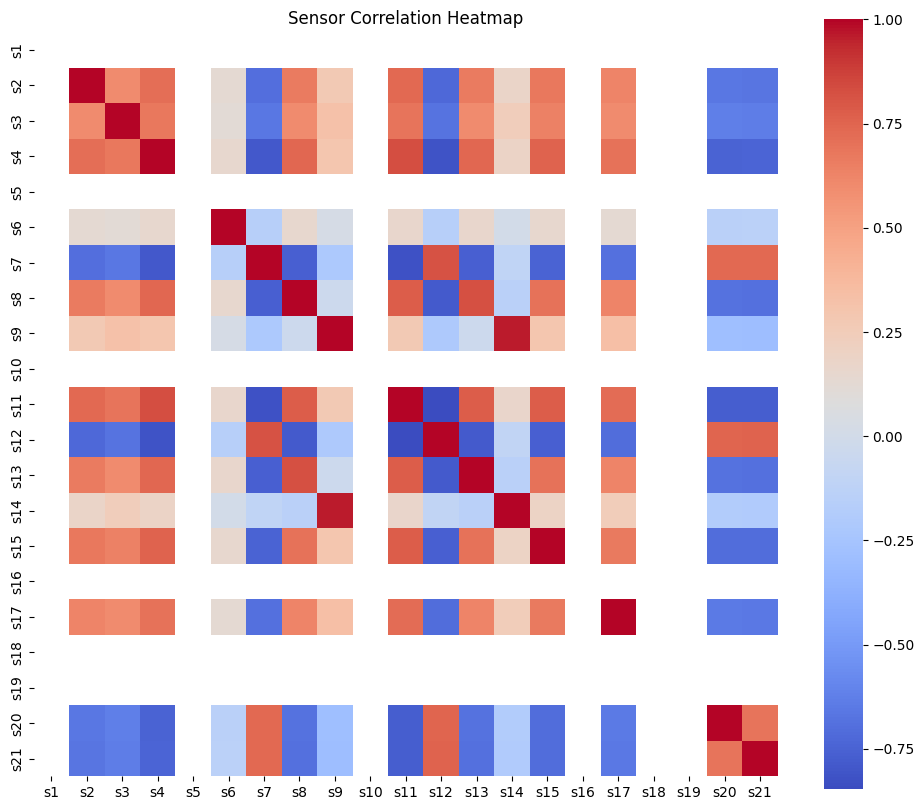

In [48]:
import seaborn as sns

# Compute correlation matrix
correlation = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=False, fmt=".2f", square=True)
plt.title('Sensor Correlation Heatmap')
plt.show()


In [49]:
# Focus only on selected higher-variance sensors to keep it readable
selected = ['s3', 's4', 's7', 's9', 's11', 's12', 's14', 's17']
corr_matrix = df[selected].corr()
print(corr_matrix.round(2))
#we got s9 & s14: 0.96, s11 & s12: –0.85, s4 & s11: 0.83, s4 & s12: –0.82

       s3    s4    s7    s9   s11   s12   s14   s17
s3   1.00  0.68 -0.66  0.32  0.70 -0.68  0.24  0.60
s4   0.68  1.00 -0.79  0.30  0.83 -0.82  0.19  0.70
s7  -0.66 -0.79  1.00 -0.22 -0.82  0.81 -0.11 -0.69
s9   0.32  0.30 -0.22  1.00  0.27 -0.21  0.96  0.34
s11  0.70  0.83 -0.82  0.27  1.00 -0.85  0.16  0.72
s12 -0.68 -0.82  0.81 -0.21 -0.85  1.00 -0.10 -0.70
s14  0.24  0.19 -0.11  0.96  0.16 -0.10  1.00  0.25
s17  0.60  0.70 -0.69  0.34  0.72 -0.70  0.25  1.00


In [50]:
#Feature Engineering
# Feature Engineering: Rolling Statistics and Slope Calculation

import pandas as pd
import numpy as np

# Subset to selected sensors + metadata
keep_cols = ['unit', 'time', 'RUL', 's3', 's4', 's7', 's9', 's17'] # Add 'RUL' for reference

# Create a new DataFrame with selected columns
df_sel = df[keep_cols].copy()

# Define rolling window size (e.g., 20 cycles)
window = 20

# Feature engineering: rolling statistics and slope per unit
for sensor in ['s3','s4','s7','s9','s17']:
    # Rolling mean
    df_sel[f'{sensor}_roll_mean_{window}'] = (
        df_sel.groupby('unit')[sensor]
              .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )
    # Rolling std
    df_sel[f'{sensor}_roll_std_{window}'] = (
        df_sel.groupby('unit')[sensor]
              .transform(lambda x: x.rolling(window, min_periods=1).std())
    )
    # Rolling slope (linear trend) using numpy.polyfit over window
    def rolling_slope(x):
        idx = np.arange(len(x))
        if len(x) < 2:
            return np.nan
        coef = np.polyfit(idx, x, 1)[0]
        return coef
    df_sel[f'{sensor}_roll_slope_{window}'] = (
        df_sel.groupby('unit')[sensor]
              .transform(lambda x: x.rolling(window, min_periods=2).apply(rolling_slope, raw=True))
    )

# Drop the raw sensor columns if desired
# df_model = df_sel.drop(columns=['s3','s4','s7','s9','s17'])
# Otherwise, keep both raw and engineered features
df_model = df_sel.copy()

# Preview engineered features
print(df_model.filter(like=f'roll').head())


   s3_roll_mean_20  s3_roll_std_20  s3_roll_slope_20  s4_roll_mean_20  \
0      1589.700000             NaN               NaN      1400.600000   
1      1590.760000        1.499066             2.120      1401.870000   
2      1589.836667        1.918654            -0.855      1402.646667   
3      1588.075000        3.855909            -2.456      1402.452500   
4      1587.030000        4.075678            -2.273      1403.206000   

   s4_roll_std_20  s4_roll_slope_20  s7_roll_mean_20  s7_roll_std_20  \
0             NaN               NaN       554.360000             NaN   
1        1.796051             2.540       554.055000        0.431335   
2        1.850009             1.800       554.123333        0.327159   
3        1.559645             0.487       554.205000        0.313103   
4        2.159440             0.997       554.164000        0.286234   

   s7_roll_slope_20  s9_roll_mean_20  s9_roll_std_20  s9_roll_slope_20  \
0               NaN      9046.190000             NaN  

In [62]:
#Baseline Regression
# all engineered rolling features
feature_cols = [c for c in df_model.columns if 'roll_' in c]
X = df_model[feature_cols]
y = df_model['RUL']

from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=df_model['unit']))
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

from sklearn.metrics import root_mean_squared_error
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'Baseline RF RMSE: {rmse:.2f} cycles')

# Feature Importance
import pandas as pd
imps = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(imps.head(10))




Baseline RF RMSE: 34.62 cycles
s4_roll_mean_20     0.371866
s3_roll_mean_20     0.311723
s9_roll_mean_20     0.131088
s17_roll_mean_20    0.097297
s7_roll_mean_20     0.038548
s4_roll_slope_20    0.010289
s7_roll_slope_20    0.007578
s9_roll_std_20      0.005594
s3_roll_std_20      0.005053
s3_roll_slope_20    0.004492
dtype: float64


In [63]:
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error

# Select features and target
feature_cols = [col for col in df_model.columns if 'roll_' in col]
X = df_model[feature_cols]
y = df_model['RUL']
groups = df_model['unit']

# Group-based split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Train baseline XGBoost
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"XGBoost RMSE: {rmse:.2f} cycles")


XGBoost RMSE: 34.30 cycles


C:\Users\pechj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
